# Customer Churn Prediction using XGBoost + SHAP

**Objective:**  
Predict customer churn using a mix of behavioral and demographic data.  
This notebook demonstrates a full ML workflow with:
- Feature engineering and preprocessing via `pandas` and `scikit-learn`
- Model training and evaluation using `XGBoost`
- Model explainability using `SHAP` values
- Clean, business-ready outputs and structure

**Target audience:**  
Analytics leaders, hiring managers, or business partners seeking to understand churn drivers and model results.

**Outcome:**  
A clear, interpretable model that predicts customer churn and explains the best drivers or most influential features for each prediction.


In [3]:
#loading data for EDA (Exploratory Data Analysis) to check data health, understand distributions, identify datatypes, find irrelevent features
# spt feature interactions (relationships), and understand the target (feature impact on driver/class balance)
import pandas as pd
df = pd.read_csv('../data/customer_churn.csv')
df.head

<bound method NDFrame.head of       customer_id  tenure_months  monthly_spend  num_logins  support_tickets  \
0               1             39           0.62          14                2   
1               2             52          54.20          21                1   
2               3             29         344.33          17                2   
3               4             15          26.09          17                2   
4               5             43          40.26          16                0   
...           ...            ...            ...         ...              ...   
9995         9996             51          87.25          14                2   
9996         9997             59         194.49          15                2   
9997         9998             55          49.38          15                2   
9998         9999             39           3.35          19                3   
9999        10000             55         169.82          13                1   

     regi

In [4]:
# Basic info and target distribution
print("Shape:", df.shape)
print("\nClass Balance:")
print(df['churned'].value_counts(normalize=True).rename_axis("churned").reset_index(name='proportion'))

Shape: (10000, 13)

Class Balance:
   churned  proportion
0        0      0.9167
1        1      0.0833


In [5]:
# Check for missing values and duplicates
print("Missing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

Missing values per column:
customer_id                  0
tenure_months                0
monthly_spend                0
num_logins                   0
support_tickets              0
region                       0
account_type                 0
device_type                  0
uses_advanced_features       0
email_opt_in                 0
survey_score                 0
feature_flag_random_noise    0
churned                      0
dtype: int64

Duplicate rows: 0


In [6]:
# Data types summary
df.dtypes.value_counts()

# Quick look at categorical vs numeric columns
categoricals = df.select_dtypes(include='object').columns.tolist()
numerics = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categoricals)
print("Numeric features:", [col for col in numerics if col != 'churned'])

Categorical features: ['region', 'account_type', 'device_type', 'feature_flag_random_noise']
Numeric features: ['customer_id', 'tenure_months', 'monthly_spend', 'num_logins', 'support_tickets', 'uses_advanced_features', 'email_opt_in', 'survey_score']


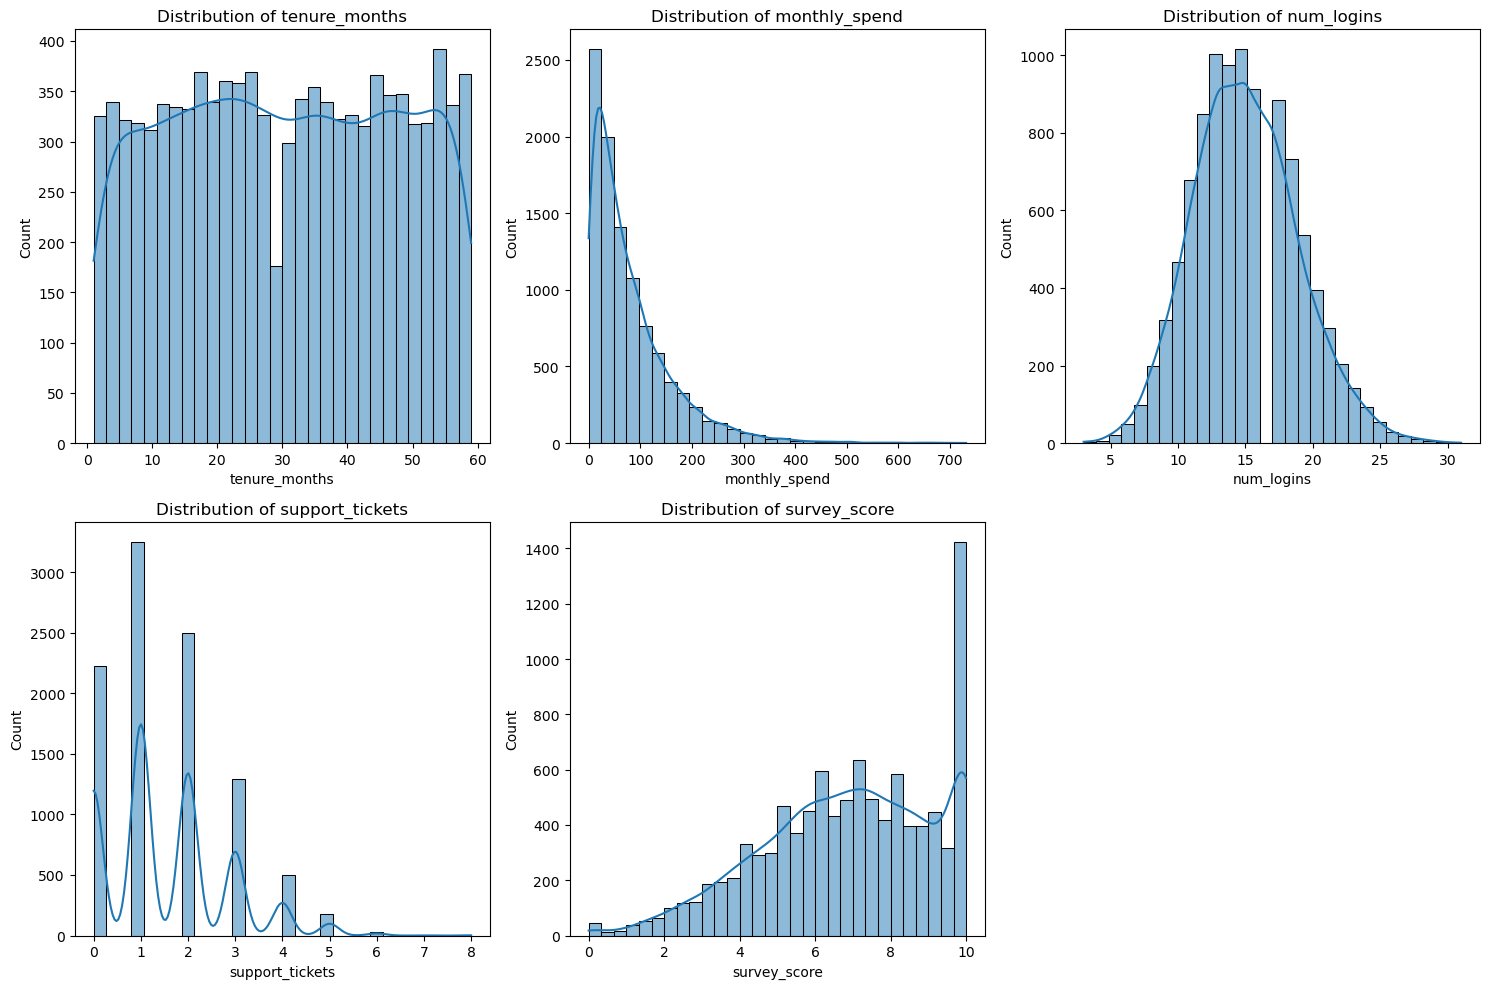

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot numeric feature distributions (excluding customer_id)
features_to_plot = ['tenure_months', 'monthly_spend', 'num_logins', 'support_tickets', 'survey_score']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

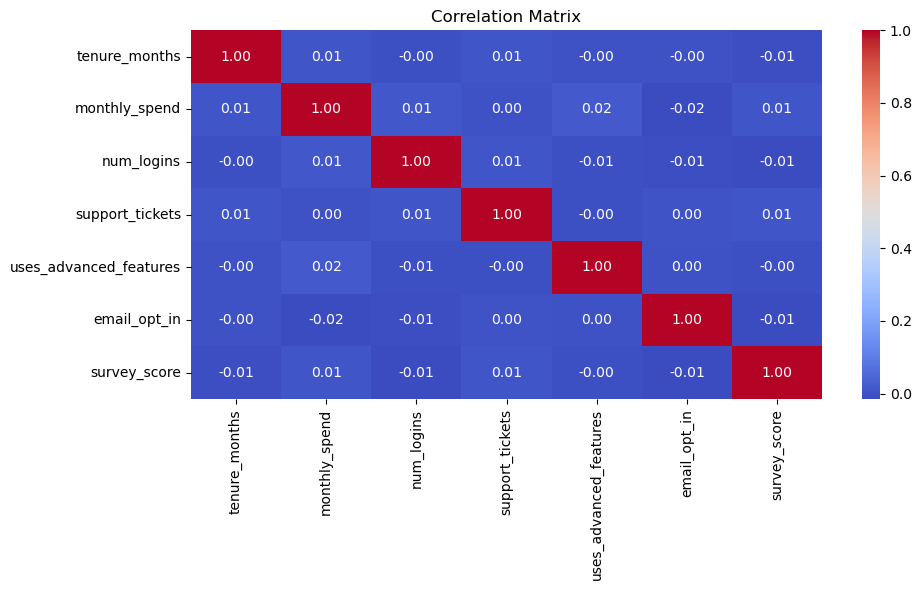

In [8]:
# Correlation matrix for numeric features (excluding customer_id)
numeric_cols = ['tenure_months', 'monthly_spend', 'num_logins', 'support_tickets', 'uses_advanced_features', 'email_opt_in', 'survey_score']

corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [9]:
#above plot shows us No multicollinearity, which means it's a great dataset for tree-based models like XGBoost

In [10]:
# Churn rate by categorical feature
cat_features = ['region', 'account_type', 'device_type', 'feature_flag_random_noise']

for col in cat_features:
    churn_rate = df.groupby(col)['churned'].mean().sort_values(ascending=False)
    print(f"\nChurn Rate by {col}:\n{churn_rate}")


Churn Rate by region:
region
West     0.086903
East     0.086337
South    0.082826
North    0.077314
Name: churned, dtype: float64

Churn Rate by account_type:
account_type
Free          0.242330
Basic         0.029691
Enterprise    0.028914
Premium       0.025827
Name: churned, dtype: float64

Churn Rate by device_type:
device_type
Tablet     0.087534
Desktop    0.082426
Mobile     0.079939
Name: churned, dtype: float64

Churn Rate by feature_flag_random_noise:
feature_flag_random_noise
D    0.088003
C    0.083367
B    0.082104
A    0.079681
Name: churned, dtype: float64


Above tells us that account_type appears to be a stronger driver, region and device type and feature_flag_random_noise we need SHAP to evaluate.

## Exploratory Data Analysis Summary

### Dataset Overview
- **10,000 rows**, 13 columns
- Target variable (`churned`) is **highly imbalanced** (8.3% churn, 91.7% retained)
- No missing or duplicate records means we don't need additional data cleansing steps

### Numeric Features
| Feature              | Distribution Shape       | Observations |
|----------------------|--------------------------|--------------|
| `tenure_months`      | Uniform/random           | wide spread, no bias to early or late tenures |
| `monthly_spend`      | Right-skewed (long tail) | Most spend <$100, couple of high spenders |
| `num_logins`         | Normal (bell curve)       | Good range, centered around 15 logins |
| `support_tickets`    | Spiky, right-skewed       | Many users have 0–2 tickets, some heavy users |
| `survey_score`       | Slight right skew         | Many high scores (8–10), fewer detractors |

### Categorical Feature Churn Rates
- **`account_type`** is the strongest driver:
  - `Free` users churn at **24%**
  - `Premium` and `Enterprise` users churn at **~2.5%**
- Small variation by `region` and `device_type`, may be useful in interactions
- `feature_flag_random_noise` will be evaluated with SHAP testing

### Correlations
- No strong correlations between numeric features
- Good independence — XGBoost, being tree based, will explore interaction effects naturally

### Next Step
- Build a preprocessing pipeline with encoding and feature selection
- Train an XGBoost classifier on the prepared data


In [12]:
from sklearn.model_selection import train_test_split

# Drop identifier column and split features/target
df_model = df.drop(columns=['customer_id'])
X = df_model.drop(columns=['churned'])
y = df_model['churned']

# Define feature types
categorical_features = ['region', 'account_type', 'device_type', 'feature_flag_random_noise']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Confirm dimensions
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10000, 11)
y shape: (10000,)


### Preparing Features and Target

In the step above, we:
- Drop `customer_id`, which is a unique identifier not useful for modeling as it will cause overfitting
- Separate the target (`churned`) from the feature set
- Define which features are categorical and which are numeric

This prepares the dataset for:
- One-hot encoding of categorical features
- Model training using only relevant inputs
- Later SHAP analysis to understand driver importance

In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# One-hot encode categorical features; passthrough numeric ones. 
#Bundles preprocessing into reusable object
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Leave numeric features unchanged
)

In [47]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Define the XGBoost model parameters
# conservative depth to avoid overfitting, log loss focuses on probablistic performance for churn risk scoring)
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

# Chains preproprocessing and modeling, into one full pipeline object with preprocessing + model
#helps us with integration, SHAP, cross-validation, and hyperparameter tuning
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', xgb_model)
])

In [48]:
from sklearn.model_selection import train_test_split

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

C:\Users\james\anaconda3\envs\timeseries\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region', 'account_type',
                                                   'device_type',
                                                   'feature_flag_random_noise'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on test set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # for AUC and threshold tuning
# Print metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba).round(4))

Classification Report:

              precision    recall  f1-score   support

           0      0.957     0.983     0.970      1833
           1      0.735     0.515     0.606       167

    accuracy                          0.944      2000
   macro avg      0.846     0.749     0.788      2000
weighted avg      0.938     0.944     0.939      2000


Confusion Matrix:
[[1802   31]
 [  81   86]]

ROC AUC Score: 0.9718


### Model Evaluation Summary and Next Steps

The initial XGBoost model performs well on the test set:

- **Accuracy:** 94.4%
- **AUC:** 0.97 — strong separation between churners and non-churners
- **Precision (churn class):** 0.74 — when the model predicts churn, it's correct 74% of the time
- **Recall (churn class):** 0.52 — it identifies about half of actual churners

**Confusion Matrix:**

- **True Negatives (1802):** Non-churners correctly predicted
- **False Positives (31):** Non-churners incorrectly flagged as churners
- **False Negatives (81):** Churners incorrectly predicted as retained
- **True Positives (86):** Churners correctly predicted

**Key Metrics:**

- **Precision (Churn class = 1):** 0.735  
  Of all customers predicted as churners, about 74% actually churned  
  Helps understand cost of false alarms

- **Recall (Churn class = 1):** 0.515  
  Of all true churners, only about 52% were caught  
  Important when the business cost of missing a churner is high

- **F1 Score (Churn class = 1):** 0.606  
  Harmonic mean of precision and recall — good summary metric when class imbalance exists

- **Accuracy:** 0.944  
  Overall correct predictions — but misleading due to imbalance (most customers don’t churn)

- **ROC AUC Score:** 0.9718  
  Indicates strong probability ranking — the model is very good at separating churners from non-churners even if the threshold is not ideal

**Summary:**  
The model performs well overall and is particularly strong in identifying non-churners. It has a strong ROC AUC, suggesting high discriminatory power. However, recall on actual churners is relatively low, which is common in imbalanced classification problems and can be improved through threshold tuning or boosting recall as a specific metric.


The model is highly effective at identifying retained customers, but misses nearly half of actual churners — a typical challenge with imbalanced datasets.

**Next Steps:**

- Run SHAP analysis to understand which features drive predictions
- Adjust the decision threshold to prioritize recall where churn prevention is critical
- Apply hyperparameter tuning to optimize performance
- Explore feature engineering or selection based on SHAP insights

These refinements will improve the model’s recall and interpretability, supporting more effective business decisions around churn intervention.


In [50]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Updated encoder with sparse=False to keep as dense array
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

In [51]:
# Get one-hot encoded column names
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_cols = ohe.get_feature_names_out(categorical_features)

# Combine encoded categorical and passthrough numeric columns
all_feature_names = list(encoded_cols) + numeric_features

# Re-transform X_test
X_encoded = encoder.transform(X_test)

# Recreate SHAP explainer with readable feature names
explainer = shap.Explainer(model, X_encoded, feature_names=all_feature_names)
shap_values = explainer(X_encoded)

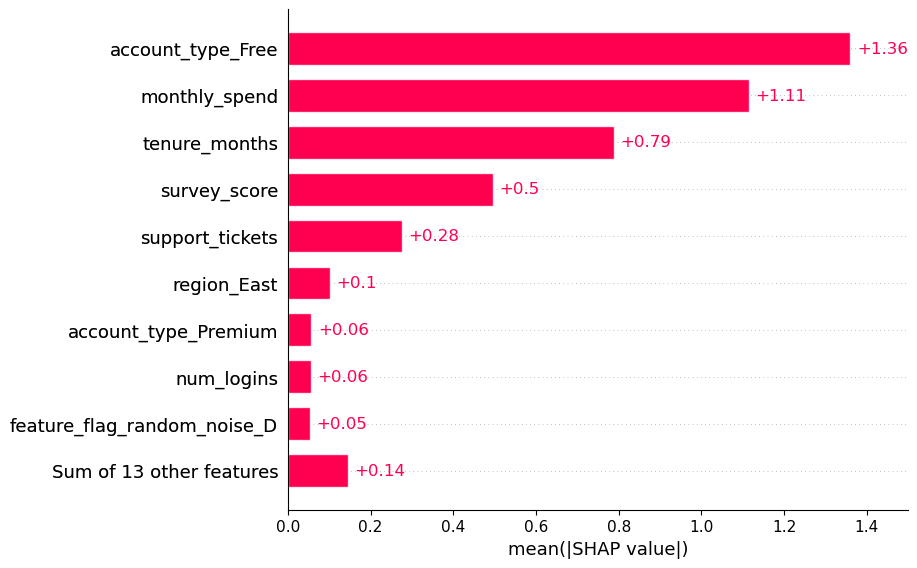

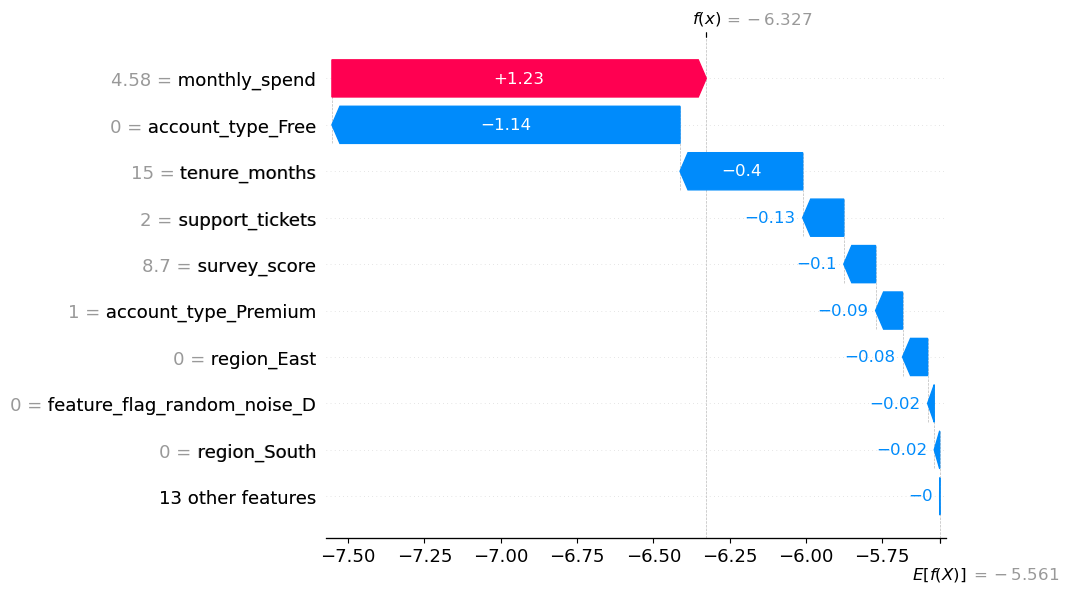

In [52]:
# Summary bar chart of global importance
shap.plots.bar(shap_values)

# Waterfall plot for a single customer
shap.plots.waterfall(shap_values[0])

### SHAP Interpretation Summary

SHAP values help explain how each feature contributes to a prediction, making the model interpretable at both global and individual levels.

#### Global Feature Importance (Summary Plot)

The summary bar chart shows which features have the greatest average impact on churn predictions.

**Top Predictors of Churn:**
- `account_type_Free`: Most consistent indicator of higher churn
- `monthly_spend`: Higher spend is typically linked to retention
- `tenure_months`: Shorter tenure increases churn risk
- `survey_score`: Low satisfaction scores correlate with churn
- `support_tickets`: More support friction often precedes churn

These insights validate key behavioral drivers and give early domain knowledge into churn patterns — even before predictions are deployed.

#### Individual Prediction Example (Waterfall Plot)

We examined a sample customer to show how the model adjusts its baseline churn estimate based on that customer’s profile.

- **Red bars** increase churn likelihood
- **Blue bars** decrease churn likelihood

This shows how features interact in specific decisions, and gives us trust in how the model behaves at the individual level.

#### Why This Matters for Business Strategy and Model Tuning

SHAP adds value even before prediction by showing what the model is learning and where key decisions are made:

- **For business:** Helps teams understand which levers (e.g., plan tier, support issues) matter most, and where to focus retention efforts.
- **For modeling:** Identifies early split features, feature quality, and areas where tuning (e.g., thresholds, interactions) could improve performance.

By interpreting the model this way, we gain both predictive power and business relevance — building better models *and* smarter decisions.


In [53]:
#Now we will use our model to predict who will churn
#Select active customers
df_unchurned = df[df['churned']==0].copy()
active_customers = df_unchurned
# Save original customer ID for reporting later
active_customers['original_customer_id'] = active_customers['customer_id']
active_customers['customer_id'].head()

0    1
1    2
2    3
3    4
4    5
Name: customer_id, dtype: int64

In [54]:
# Drop target column and any identifiers not used by the model
X_active = active_customers.drop(columns=['churned', 'customer_id'])

# Predict churn probability
churn_proba = pipeline.predict_proba(X_active)[:, 1]

# Add predictions back to the active customer data
active_customers['churn_probability'] = churn_proba

In [37]:
# Assign risk ratings via risk classification rating
def label_risk(p):
    if p >= 0.8:
        return 'High'
    elif p >= 0.5:
        return 'Medium'
    else:
        return 'Low'

active_customers['churn_risk_rating'] = active_customers['churn_probability'].apply(label_risk)

In [39]:
# Show sorted predictions
churn_risk_output = active_customers[['original_customer_id', 'churn_probability', 'churn_risk_rating', 'tenure_months']]
churn_risk_output = churn_risk_output.sort_values(by='churn_probability', ascending=False)


# Optional export
churn_risk_output.to_csv('../reports/predicted_churn_risks.csv', index=False)

In [45]:
# Show most valuable at-risk customers
cols_to_show = [
    'original_customer_id',
    'churn_probability',
    'churn_risk_rating',
    'tenure_months',
    'monthly_spend',
    'account_type'
]

# Sort by churn risk and spend — highest value, highest risk
top_valuable_risks = active_customers[cols_to_show] \
    .sort_values(by=['churn_probability', 'monthly_spend'], ascending=[False, False]) \
    .head(10)

top_valuable_risks['estimated_annual_value'] = top_valuable_risks['monthly_spend'] * 12

top_valuable_risks

,original_customer_id,churn_probability,churn_risk_rating,tenure_months,monthly_spend,account_type,estimated_annual_value
5254,5255,0.919926,High,5,20.50,Free,246.00
7287,7288,0.840190,High,4,145.26,Free,1743.12
2671,2672,0.825106,High,1,247.02,Free,2964.24
999,1000,0.791906,Medium,47,23.24,Free,278.88
5088,5089,0.782930,Medium,5,73.13,Free,877.56
2762,2763,0.774409,Medium,37,34.55,Free,414.60
8410,8411,0.769999,Medium,36,38.00,Free,456.00
8582,8583,0.761741,Medium,48,8.79,Free,105.48
6194,6195,0.752909,Medium,27,25.95,Free,311.40
7202,7203,0.751444,Medium,11,14.41,Free,172.92


### Final Prediction: High-Risk, High-Value Customers

Using our trained XGBoost churn model, we generated churn probability scores for all currently active customers. These predictions represent the likelihood that each customer will churn in the near future.

We classified customers into three churn risk categories:
- **High Risk (≥ 0.80 probability)**
- **Medium Risk (0.50–0.79)**
- **Low Risk (< 0.50)**

To support business decision-making, we also incorporated:
- **Monthly spend** to highlight customer value
- **Tenure** to flag newer customers with low retention
- **Account type** to distinguish Free vs Paid tiers

#### Top 10 Most Valuable Customers at Churn Risk

We prioritized customers with both **high churn probability** and **high spend** to help focus retention resources where the business impact is greatest.

This output simulates how a churn model would be used in a production setting to:
- Trigger targeted retention offers
- Inform account management or support outreach
- Forecast revenue risk exposure

The results have been exported to `../reports/predicted_churn_risks.csv` and can be updated weekly or daily in a production pipeline.
